In [44]:
# Import statements
import copy
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
import math
from sklearn.model_selection import train_test_split

# 0. Checking CUDA Availability + Making Sure GPU is Utilized

In [45]:
print("PyTorch Version: " + torch.__version__)
print("CUDA Availability: " + str(torch.cuda.is_available()))
print("Device Count: " + str(torch.cuda.device_count()) + "\n")

current = torch.cuda.current_device()

print("Current Device Index: " + str(current))
print("Current Device Object: " + str(torch.cuda.device(current)))
print("Current Device Name: " + torch.cuda.get_device_name(current))

PyTorch Version: 2.4.1+cu124
CUDA Availability: True
Device Count: 1

Current Device Index: 0
Current Device Object: <torch.cuda.device object at 0x771040757c40>
Current Device Name: NVIDIA GeForce RTX 4060 Laptop GPU


# 1-1a. Simulate a Function

The functions I will be simulating are $ f(x) = sgn(\frac{sin(4x)}{1.1 + cos(2x)}) $ and $ f(x) = \frac{cos(x)}{sin(x) + 1.1} $.

### 1. Generating Training Data

In [46]:
# Function representation of the simulated function
def groundtruth_function(x):
    fx = math.sin(4 * x) / (1.1 + math.cos(2 * x))

    if fx == 0:
        return 0
    elif fx > 0:
        return 1
    else:
        return -1

# Hold generated data
data = []

# Parameters to generate data points from start to end in jump_rate increments
start = -5
end = 5
jump_rate = 0.001

# Generate data points
while start <= end:
    data.append([start, groundtruth_function(start)])
    start += jump_rate

# Convert to numpy arrays (for train-test split), one for input (X) and one for output (y)
X = np.array(data)[:, 0].reshape(-1, 1)
y = np.array(data)[:, 1].reshape(-1, 1)
 
# Train-test split for model evaluation (sklearn is only used for this, not for model training)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Convert to 2D PyTorch tensors, make sure they're on the GPU
X_train = torch.tensor(X_train, dtype=torch.float32).clone().detach().cuda()
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).clone().detach().cuda()
X_test = torch.tensor(X_test, dtype=torch.float32).clone().detach().cuda()
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).clone().detach().cuda()

# Print shapes of the data to sanity check
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([7000, 1]) torch.Size([7000, 1]) torch.Size([3000, 1]) torch.Size([3000, 1])


### 1. Generating Training Data (BONUS)

In [47]:
# Function representation of the simulated function
def groundtruth_function2(x):
    fx = math.cos(x) / (math.sin(x) + 1.1)
    return fx

# Hold generated data
data2 = []

# Parameters to generate data points from start to end in jump_rate increments
start = -5
end = 5
jump_rate = 0.001

# Generate data points
while start <= end:
    data2.append([start, groundtruth_function2(start)])
    start += jump_rate

# Convert to numpy arrays (for train-test split), one for input (X) and one for output (y)
X2 = np.array(data2)[:, 0].reshape(-1, 1)
y2 = np.array(data2)[:, 1].reshape(-1, 1)

# Train-test split for model evaluation (sklearn is only used for this, not for model training)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, train_size=0.7, shuffle=True)

# Convert to 2D PyTorch tensors, make sure they're on the GPU
X_train2 = torch.tensor(X_train2, dtype=torch.float32).clone().detach().cuda()
y_train2 = torch.tensor(y_train2, dtype=torch.float32).reshape(-1, 1).clone().detach().cuda()
X_test2 = torch.tensor(X_test2, dtype=torch.float32).clone().detach().cuda()
y_test2 = torch.tensor(y_test2, dtype=torch.float32).reshape(-1, 1).clone().detach().cuda()

# Print shapes of the data to sanity check
print(X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape)

torch.Size([7000, 1]) torch.Size([7000, 1]) torch.Size([3000, 1]) torch.Size([3000, 1])


### 2. Defining the Models

In [48]:
#Model 0--architecture from slides
class Model0(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.network_stack = torch.nn.Sequential(
            torch.nn.Linear(1, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 1)
        )

    def forward(self, x):
        output = self.network_stack(x)
        return output

#Model 1--architecture from slides
class Model1(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.network_stack = torch.nn.Sequential(
            torch.nn.Linear(1, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 15),
            torch.nn.ReLU(),
            torch.nn.Linear(15, 4),
            torch.nn.ReLU(),
            torch.nn.Linear(4, 1)
        )
    
    def forward(self, x):
        output = self.network_stack(x)
        return output

#Model 2--architecture from slides
class Model2(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.network_stack = torch.nn.Sequential(
            torch.nn.Linear(1, 190),
            torch.nn.ReLU(),
            torch.nn.Linear(190, 1),
        )
    
    def forward(self, x):
        output = self.network_stack(x)
        return output


# Instantiate the models and print them to check the architecture
model0 = Model0().to('cuda')
print("Model 0 # Parameters: " + str(sum(p.numel() for p in model0.parameters() if p.requires_grad)))
print(model0)

model1 = Model1().to('cuda')
print("Model 1 # Parameters: " + str(sum(p.numel() for p in model1.parameters() if p.requires_grad)))
print(model1)

model2 = Model2().to('cuda')
print("Model 2 # Parameters: " + str(sum(p.numel() for p in model2.parameters() if p.requires_grad)))
print(model2)

Model 0 # Parameters: 571
Model0(
  (network_stack): Sequential(
    (0): Linear(in_features=1, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=5, bias=True)
    (13): ReLU()
    (14): Linear(in_features=5, out_features=1, bias=True)
  )
)
Model 1 # Parameters: 572
Model1(
  (network_stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=18, bias=True)
    (3): ReLU()
    (4): Linear(in_features=18, out_features=15, bias=True)
    (5): ReLU()
    (6): Linear(in_features=15, out_features=4

### 3. Training/Testing the Models

In [49]:
# Loss function (shared between models)
loss_fn = torch.nn.MSELoss()  # mean square error

# Optimizer for each model
optimizer0 = torch.optim.Adam(model0.parameters(), lr=0.0001)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)

# Hyperparameters
n_epochs = 20000   # Number of epochs to run
batch_size = 100  # Size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model0
best_mse0 = np.inf   # Init to infinity--can only go lower
best_weights0 = None # Placeholder for best weights
best_epoch0 = None   # Placeholder for best epoch
epoch_test_history0 = [] # Empty list for epoch testing loss history
epoch_train_history0 = [] # Empty list for epoch training loss history

# Hold the best model1
best_mse1 = np.inf  # Init to infinity--can only go lower
best_weights1 = None # Placeholder for best weights
best_epoch1 = None   # Placeholder for best epoch
epoch_test_history1 = [] # Empty list for epoch testing loss history
epoch_train_history1 = [] # Empty list for epoch training loss history

# Hold the best model2
best_mse2 = np.inf  # Init to infinity--can only go lower
best_weights2 = None # Placeholder for best weights
best_epoch2 = None   # Placeholder for best epoch
epoch_test_history2 = [] # Empty list for epoch testing loss history
epoch_train_history2 = [] # Empty list for epoch training loss history
 
# Training loop
for epoch in range(n_epochs):
    # Set models to train mode
    model0.train()
    model1.train()
    model2.train()

    # Progress bar, disabled to avoid clutter--can be enabled for debugging
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:

        # Epoch descriptor
        bar.set_description(f"Epoch {epoch}")

        epoch_loss0 = 0.0
        epoch_loss1 = 0.0
        epoch_loss2 = 0.0
        batch_nums = 0

        # Loop through each batch
        for start in bar:
            # Get batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            # Pass forward
            y_pred0 = model0(X_batch)
            y_pred1 = model1(X_batch)
            y_pred2 = model2(X_batch)

            loss0 = loss_fn(y_pred0, y_batch)
            loss1 = loss_fn(y_pred1, y_batch)
            loss2 = loss_fn(y_pred2, y_batch)

            epoch_loss0 += float(loss0)
            epoch_loss1 += float(loss1)
            epoch_loss2 += float(loss2)

            batch_nums += 1

            # Pass backward
            optimizer0.zero_grad()
            optimizer1.zero_grad()
            optimizer2.zero_grad()

            loss0.backward()
            loss1.backward()
            loss2.backward()

            # Update weights
            optimizer0.step()
            optimizer1.step()
            optimizer2.step()

            # Print progress
            bar.set_postfix(train_mse0=float(loss0), train_mse1=float(loss1), train_mse2=float(loss2))
        
        # Append loss to the histories lists (batch average for epoch)
        epoch_train_history0.append(epoch_loss0 / batch_nums)
        epoch_train_history1.append(epoch_loss1 / batch_nums)
        epoch_train_history2.append(epoch_loss2 / batch_nums)

    # Set models to eval mode
    model0.eval()
    model1.eval()
    model2.eval()

    # Get predicted values for the test set
    y_pred0 = model0(X_test)
    y_pred1 = model1(X_test)
    y_pred2 = model2(X_test)

    # Calculate the loss
    mse0 = float(loss_fn(y_pred0, y_test))
    mse1 = float(loss_fn(y_pred1, y_test))
    mse2 = float(loss_fn(y_pred2, y_test))

    # Append loss to the histories lists
    epoch_test_history0.append(mse0)
    epoch_test_history1.append(mse1)
    epoch_test_history2.append(mse2)

    # Update best MSE0 if needed
    if mse0 < best_mse0:
        best_mse0 = mse0
        best_epoch0 = epoch
        best_weights0 = copy.deepcopy(model0.state_dict())
    
    # Update best MSE1 if needed
    if mse1 < best_mse1:
        best_mse1 = mse1
        best_epoch1 = epoch
        best_weights1 = copy.deepcopy(model1.state_dict())
    
    # Update best MSE2 if needed
    if mse2 < best_mse2:
        best_mse2 = mse2
        best_epoch2 = epoch
        best_weights2 = copy.deepcopy(model2.state_dict())
    

### 3. Training/Testing the Models (BONUS)

In [50]:
# Reset models
model0 = Model0().to('cuda')
model1 = Model1().to('cuda')
model2 = Model2().to('cuda')

# Loss function (shared between models)
loss_fn = torch.nn.MSELoss()

# Optimizer for each model
optimizer0 = torch.optim.Adam(model0.parameters(), lr=0.0001)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)

# Hyperparameters
n_epochs = 20000   # Number of epochs to run
batch_size = 100  # Size of each batch
batch_start = torch.arange(0, len(X_train2), batch_size)

# Hold the best model0
best2_mse0 = np.inf   # Init to infinity--can only go lower
best2_weights0 = None # Placeholder for best weights
best2_epoch0 = None   # Placeholder for best epoch
epoch2_test_history0 = [] # Empty list for epoch testing loss history
epoch2_train_history0 = [] # Empty list for epoch training loss history

# Hold the best model1
best2_mse1 = np.inf  # Init to infinity--can only go lower
best2_weights1 = None # Placeholder for best weights
best2_epoch1 = None   # Placeholder for best epoch
epoch2_test_history1 = [] # Empty list for epoch testing loss history
epoch2_train_history1 = [] # Empty list for epoch training loss

# Hold the best model2
best2_mse2 = np.inf  # Init to infinity--can only go lower
best2_weights2 = None # Placeholder for best weights
best2_epoch2 = None   # Placeholder for best epoch
epoch2_test_history2 = [] # Empty list for epoch testing loss history
epoch2_train_history2 = [] # Empty list for epoch training loss history

# Training loop
for epoch in range(n_epochs):
    # Set models to train mode
    model0.train()
    model1.train()
    model2.train()

    # Progress bar, disabled to avoid clutter--can be enabled for debugging
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:

        # Epoch descriptor
        bar.set_description(f"Epoch {epoch}")

        epoch_loss0 = 0.0
        epoch_loss1 = 0.0
        epoch_loss2 = 0.0
        batch_nums = 0

        # Loop through each batch
        for start in bar:
            # Get batch
            X_batch = X_train2[start:start+batch_size]
            y_batch = y_train2[start:start+batch_size]

            # Pass forward
            y_pred0 = model0(X_batch)
            y_pred1 = model1(X_batch)
            y_pred2 = model2(X_batch)

            loss0 = loss_fn(y_pred0, y_batch)
            loss1 = loss_fn(y_pred1, y_batch)
            loss2 = loss_fn(y_pred2, y_batch)

            epoch_loss0 += float(loss0)
            epoch_loss1 += float(loss1)
            epoch_loss2 += float(loss2)

            batch_nums += 1

            # Pass backward
            optimizer0.zero_grad()
            optimizer1.zero_grad()
            optimizer2.zero_grad()

            loss0.backward()
            loss1.backward()
            loss2.backward()

            # Update weights
            optimizer0.step()
            optimizer1.step()
            optimizer2.step()

            # Print progress
            bar.set_postfix(train_mse0=float(loss0), train_mse1=float(loss1), train_mse2=float(loss2))
        
        # Append loss to the histories lists (batch average for epoch)
        epoch2_train_history0.append(epoch_loss0 / batch_nums)
        epoch2_train_history1.append(epoch_loss1 / batch_nums)
        epoch2_train_history2.append(epoch_loss2 / batch_nums)

    # Set models to eval mode
    model0.eval()
    model1.eval()
    model2.eval()

    # Get predicted values for the test set
    y_pred0 = model0(X_test2)
    y_pred1 = model1(X_test2)
    y_pred2 = model2(X_test2)

    # Calculate the loss
    mse0 = float(loss_fn(y_pred0, y_test2))
    mse1 = float(loss_fn(y_pred1, y_test2))
    mse2 = float(loss_fn(y_pred2, y_test2))

    # Append loss to the histories lists
    epoch2_test_history0.append(mse0)
    epoch2_test_history1.append(mse1)
    epoch2_test_history2.append(mse2)

    # Update best MSE0 if needed
    if mse0 < best2_mse0:
        best2_mse0 = mse0
        best2_epoch0 = epoch
        best2_weights0 = copy.deepcopy(model0.state_dict())
    
    # Update best MSE1 if needed
    if mse1 < best2_mse1:
        best2_mse1 = mse1
        best2_epoch1 = epoch
        best2_weights1 = copy.deepcopy(model1.state_dict())
    
    # Update best MSE2 if needed
    if mse2 < best2_mse2:
        best2_mse2 = mse2
        best2_epoch2 = epoch
        best2_weights2 = copy.deepcopy(model2.state_dict())
    


### 4. Plot Training/Testing Losses

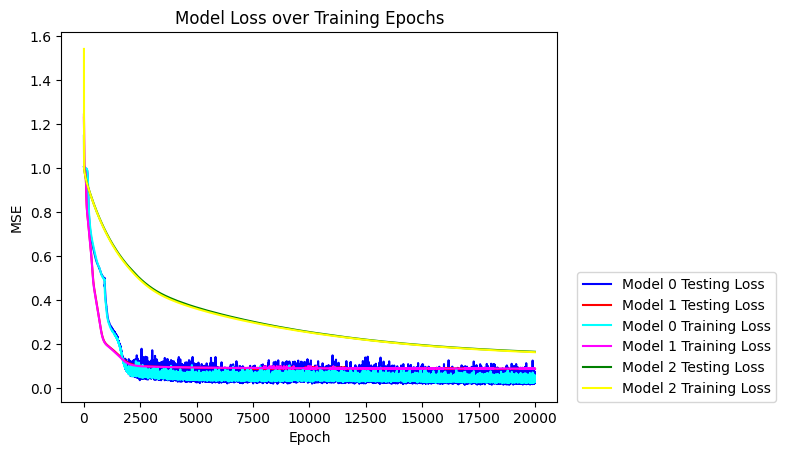

In [51]:
# Restore models and return best accuracies
model0.load_state_dict(best_weights0)
model1.load_state_dict(best_weights1)
model2.load_state_dict(best_weights2)

# Plot the loss over epochs, both training and testing
plt.plot(epoch_test_history0, color='blue', label='Model 0 Testing Loss')
plt.plot(epoch_test_history1, color='red', label='Model 1 Testing Loss')
plt.plot(epoch_train_history0, color='cyan', label='Model 0 Training Loss')
plt.plot(epoch_train_history1, color='magenta', label='Model 1 Training Loss')
plt.plot(epoch_test_history2, color='green', label='Model 2 Testing Loss')
plt.plot(epoch_train_history2, color='yellow', label='Model 2 Training Loss')

# Legend for visual clarity
plt.legend(loc=(1.04, 0))

# Axis labels
plt.xlabel('Epoch')
plt.ylabel('MSE')

# Title
plt.title('Model Loss over Training Epochs')

plt.show()

### 4. Plot Training/Testing Losses (BONUS)

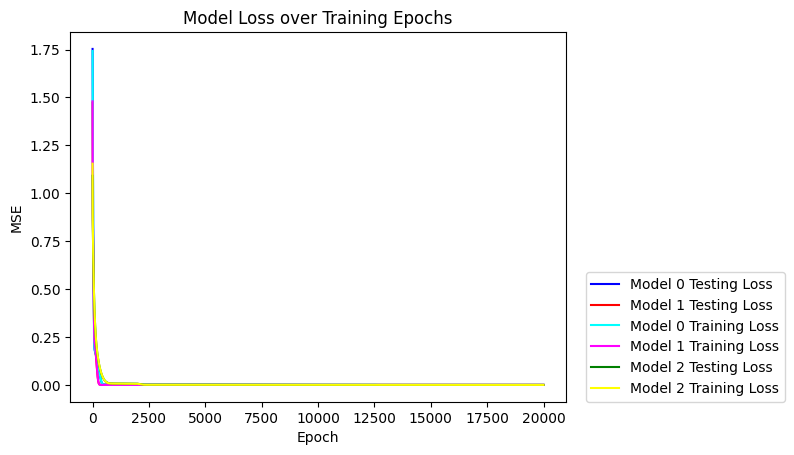

In [52]:
# Restore models and return best accuracies
model0.load_state_dict(best2_weights0)
model1.load_state_dict(best2_weights1)
model2.load_state_dict(best2_weights2)

# Plot the loss over epochs, both training and testing
plt.plot(epoch2_test_history0, color='blue', label='Model 0 Testing Loss')
plt.plot(epoch2_test_history1, color='red', label='Model 1 Testing Loss')
plt.plot(epoch2_train_history0, color='cyan', label='Model 0 Training Loss')
plt.plot(epoch2_train_history1, color='magenta', label='Model 1 Training Loss')
plt.plot(epoch2_test_history2, color='green', label='Model 2 Testing Loss')
plt.plot(epoch2_train_history2, color='yellow', label='Model 2 Training Loss')

# Legend for visual clarity
plt.legend(loc=(1.04, 0))

# Axis labels
plt.xlabel('Epoch')
plt.ylabel('MSE')

# Title
plt.title('Model Loss over Training Epochs')

plt.show()

### 5. Plotting Model Predictions Against Ground Truth

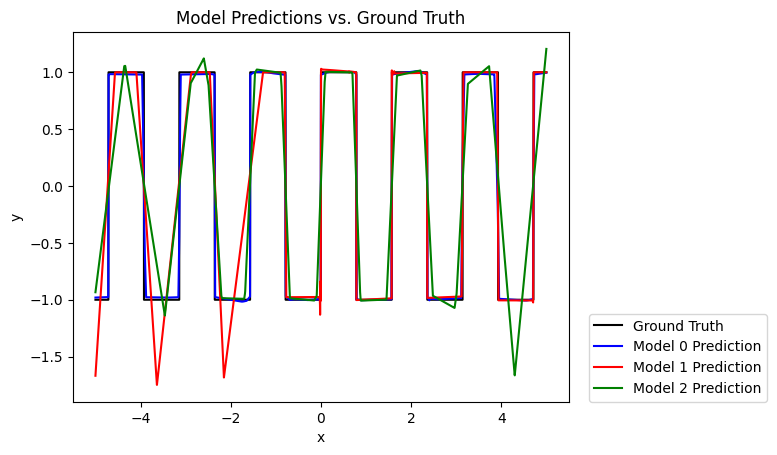

In [53]:
# Restore models and return best accuracies
model0.load_state_dict(best_weights0)
model1.load_state_dict(best_weights1)
model2.load_state_dict(best_weights2)

# Set models to eval mode
model0.eval()
model1.eval()
model2.eval()

# Generate predictions for the entire dataset
y_pred0 = model0(torch.Tensor(X).clone().detach().cuda())
y_pred1 = model1(torch.Tensor(X).clone().detach().cuda())
y_pred2 = model2(torch.Tensor(X).clone().detach().cuda())

# Plot the ground truth and the model predictions
plt.plot(X, y, color='black', label='Ground Truth')
plt.plot(X, y_pred0.detach().cpu().numpy(), color='blue', label='Model 0 Prediction')
plt.plot(X, y_pred1.detach().cpu().numpy(), color='red', label='Model 1 Prediction')
plt.plot(X, y_pred2.detach().cpu().numpy(), color='green', label='Model 2 Prediction')

# Legend for visual clarity
plt.legend(loc=(1.04, 0))

# Axis labels
plt.xlabel('x')
plt.ylabel('y')

# Title
plt.title('Model Predictions vs. Ground Truth')

plt.show()

### 5. Plotting Model Predictions Against Ground Truth (BONUS)

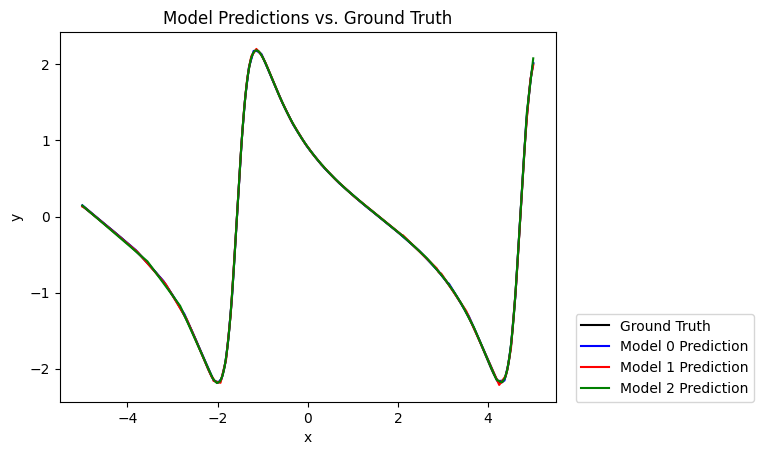

In [54]:
# Restore models and return best accuracies
model0.load_state_dict(best2_weights0)
model1.load_state_dict(best2_weights1)
model2.load_state_dict(best2_weights2)

# Set models to eval mode
model0.eval()
model1.eval()
model2.eval()

# Generate predictions for the entire dataset
y_pred0 = model0(torch.Tensor(X2).clone().detach().cuda())
y_pred1 = model1(torch.Tensor(X2).clone().detach().cuda())
y_pred2 = model2(torch.Tensor(X2).clone().detach().cuda())

# Plot the ground truth and the model predictions
plt.plot(X2, y2, color='black', label='Ground Truth')
plt.plot(X2, y_pred0.detach().cpu().numpy(), color='blue', label='Model 0 Prediction')
plt.plot(X2, y_pred1.detach().cpu().numpy(), color='red', label='Model 1 Prediction')
plt.plot(X2, y_pred2.detach().cpu().numpy(), color='green', label='Model 2 Prediction')

# Legend for visual clarity
plt.legend(loc=(1.04, 0))

# Axis labels
plt.xlabel('x')
plt.ylabel('y')

# Title
plt.title('Model Predictions vs. Ground Truth')

plt.show()



### 6. Comments

Function 1: While the parameter count was nearly identical (diff = 1), the loss graphs evenly so, model 1-2 suffered from more abnormalities in its predictions than model 0. For me, this tells me that, at least in this case, having a deeper (more layers) model can be better for fitting than a wider (less layers) model.

Function 2: The function I chose was honestly way simpler (in technical context) than I had supposed. For after 20,000 epochs (and way before that according to the loss chart), all three models were able to almost perfectly emulate the formula of the groundtruth function. Nevertheless, this still provides a valuable insight when compared with function 1: neural networks are much less adept at learning functions that change rapidly, suddenly. Function 1 flips between -1 and 1 with the single middle point of a 0 and then proceeds to stay the same for a significantly longer interval. Function 2, on the other hand, is perfectly smooth and continuous.

All models used the ReLU activation method following each layer (with the exception of the input layer and before the output layer). Model 0 had 571 parameters, Model 2 572, and Model 3 571. The sameness in the number of parameters was intentional and to see the effects of how the distribution of these parameters in the width (number of parameters in one layer) and the depth (number of layers) in a DNN can influence the overall result.

For the exact architecture/parameter count of the models, please see #2 Building the Models.

# 1-1b. Train on Actual Task

The task I will be training on is the classification of numbers according to the Modified National Institutes of Standards and Technology (NMIST) database. Each image in the database consists of 28x28 greyscale images of handwritten numbers and is labeled as a whole number from 0 to 9. For my own simplicity, I will be using two DNN models.

### 1. Getting the Data

In [55]:
# Transforms to apply to MNIST data once it's retrieved (the magic numbers are the mean and standard deviation of the MNIST dataset from what I researched)
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_set = torchvision.datasets.MNIST('./data/', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST('./data/', train=False, download=True, transform=transform)

# Loaders for the training and testing sets
training_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testing_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

# Classes for the MNIST dataset
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Print the sizes of the training and testing sets
print("Training Set Size: " + str(len(train_set)))
print("Testing Set Size: " + str(len(test_set)))

Training Set Size: 60000
Testing Set Size: 10000


### 2. Defining the Models

In [56]:
# Model 0 for MNIST
class Model0_MNIST(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.network_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)
        )
    
    def forward(self, x):
        output = self.network_stack(x)
        return output

# Model 1 for MNIST
class Model1_MNIST(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.network_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 300),
            torch.nn.ReLU(),
            torch.nn.Linear(300, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 10)
        )
    
    def forward(self, x):
        output = self.network_stack(x)
        return output

# Instantiate the models and print them to check the architecture
model0_mnist = Model0_MNIST().to('cuda')
print("Model 0 MNIST # Parameters: " + str(sum(p.numel() for p in model0_mnist.parameters() if p.requires_grad)))

model1_mnist = Model1_MNIST().to('cuda')
print("Model 1 MNIST # Parameters: " + str(sum(p.numel() for p in model1_mnist.parameters() if p.requires_grad)))

Model 0 MNIST # Parameters: 242762
Model 1 MNIST # Parameters: 322385


### 3. Training Loop

In [57]:
# Loss function for MNIST
loss_fn_mnist = torch.nn.CrossEntropyLoss()

# Optimizers for each model
optimizer0_mnist = torch.optim.Adam(model0_mnist.parameters(), lr=0.001)
optimizer1_mnist = torch.optim.Adam(model1_mnist.parameters(), lr=0.001)

# Hyperparameters
n_epochs = 125
batch_size = 64
batch_start = torch.arange(0, len(train_set), batch_size)

# Hold the best model0
best_accuracy0 = 0
best_weights0 = None
best_epoch0 = None

# Hold the best model1
best_accuracy1 = 0
best_weights1 = None
best_epoch1 = None

# Epoch history lists for model 0
epoch_test_acc_history0 = []
epoch_train_loss_history0 = []

# Epoch history lists for model 1
epoch_test_acc_history1 = []
epoch_train_loss_history1 = []

# Training loop
for epoch in range(n_epochs):
    # Set models to train mode
    model0_mnist.train()
    model1_mnist.train()

    # Progress bar, disabled to avoid clutter--can be enabled for debugging
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")

        # Initialize epoch loss, used to calculate average loss per batch
        epoch_loss0 = 0.0
        epoch_loss1 = 0.0
        batch_nums = 0

        # Loop through each batch
        for start in bar:
            # Get batch
            X_batch, y_batch = next(iter(training_loader))

            # Send batch to GPU
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')

            # Pass forward
            y_pred0 = model0_mnist(X_batch)
            y_pred1 = model1_mnist(X_batch)

            # Calculate loss
            loss0 = loss_fn_mnist(y_pred0, y_batch)
            loss1 = loss_fn_mnist(y_pred1, y_batch)

            # Update epoch loss
            epoch_loss0 += float(loss0)
            epoch_loss1 += float(loss1)
            batch_nums += 1

            # Pass backward
            optimizer0_mnist.zero_grad()
            optimizer1_mnist.zero_grad()
            loss0.backward()
            loss1.backward()

            # Update weights
            optimizer0_mnist.step()
            optimizer1_mnist.step()

            # Print progress
            bar.set_postfix(train_loss0=float(loss0), train_loss1=float(loss1))
        
        # Append loss to the histories lists (batch average for epoch)
        epoch_train_loss_history0.append(epoch_loss0 / batch_nums)
        epoch_train_loss_history1.append(epoch_loss1 / batch_nums)
    
    # Set models to eval mode
    model0_mnist.eval()
    model1_mnist.eval()

    # Initialize correct predictions
    correct0 = 0
    correct1 = 0
    total = 0

    # Loop through the testing set
    with torch.no_grad():
        # For each batch in the testing set
        for X_batch, y_batch in testing_loader:
            # Send batch to GPU
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')

            # Get predictions
            y_pred0 = model0_mnist(X_batch)
            y_pred1 = model1_mnist(X_batch)

            # Get the predicted class
            _, predicted0 = torch.max(y_pred0.data, 1)
            _, predicted1 = torch.max(y_pred1.data, 1)

            # Update correct predictions and total
            total += y_batch.size(0)
            correct0 += (predicted0 == y_batch).sum().item()
            correct1 += (predicted1 == y_batch).sum().item()
    
    # Calculate accuracy
    accuracy0 = correct0 / total
    accuracy1 = correct1 / total

    # Append accuracy to the histories lists
    epoch_test_acc_history0.append(accuracy0)
    epoch_test_acc_history1.append(accuracy1)

    # Update best accuracy0 if needed
    if accuracy0 > best_accuracy0:
        best_accuracy0 = accuracy0
        best_epoch0 = epoch
        best_weights0 = copy.deepcopy(model0_mnist.state_dict())
    
    # Update best accuracy1 if needed
    if accuracy1 > best_accuracy1:
        best_accuracy1 = accuracy1
        best_epoch1 = epoch
        best_weights1 = copy.deepcopy(model1_mnist.state_dict())




### 4. Plotting Model Accuracies

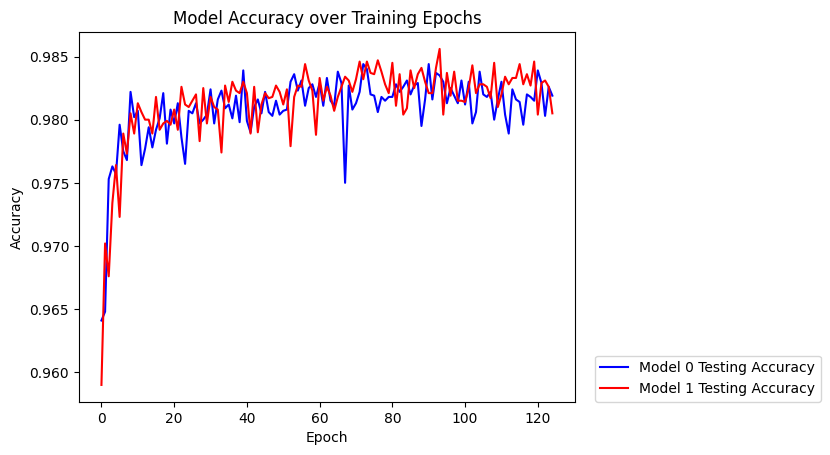

In [59]:
# Plot the accuracy over epochs in testing
plt.plot(epoch_test_acc_history0, color='blue', label='Model 0 Testing Accuracy')
plt.plot(epoch_test_acc_history1, color='red', label='Model 1 Testing Accuracy')

# Legend for visual clarity
plt.legend(loc=(1.04, 0))

# Axis labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Title
plt.title('Model Accuracy over Training Epochs')

plt.show()


### 5. Plotting Model Training Losses

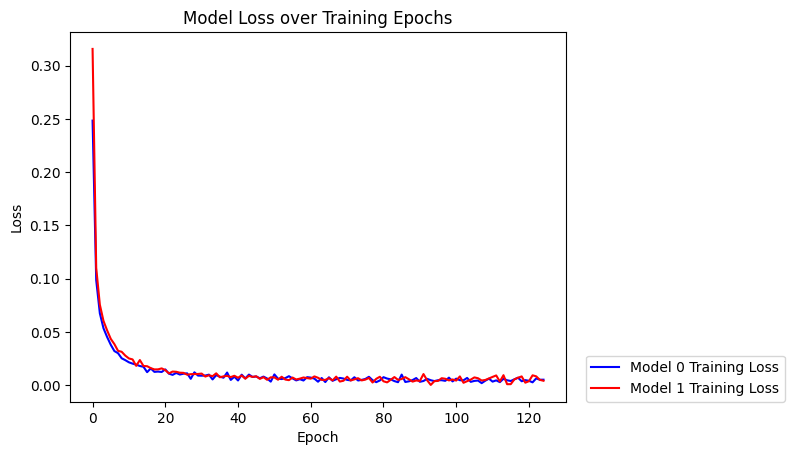

In [60]:
# Plot the loss over epochs, training
plt.plot(epoch_train_loss_history0, color='blue', label='Model 0 Training Loss')
plt.plot(epoch_train_loss_history1, color='red', label='Model 1 Training Loss')

# Legend for visual clarity
plt.legend(loc=(1.04, 0))

# Axis labels
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Title
plt.title('Model Loss over Training Epochs')

plt.show()

### 6. Comments

For the exact architecture of the models, see #2 Defining the Models of the training for an actual task subtask.

Because I was training using the MNIST database, which consists of 28x28 images, it only makes sense that I would factor in each individual pixel for each input image as a parameter. 28 * 28 = 784, which means that the input layer would start out with 784 parameters. The end result of this classifier is to classify the 28x28 image into one of 10 possible categories (0, 1, 2, 3, ..., 9), which means that the output should be size 10. Going from 784 to 10, I embraced a completely monotonic neural network structure in which both models, model 0 and model 1, decreased their parameters with each next layer. The main difference between the two is the rate at which they did it and the number of layers they used before getting to the end output of 10. Lastly, just like the earlier subtask, each neural network used a ReLU activation function for each internal layer with the exception of the one prior to the output. As for results, both models performed handsomely in the face of only 125 epochs (though, they have many, many times more parameters than the simulated function models). I am disappointed that while, in some minute spikes, model 1 performed better than model 0, model 0 performed very similarly to model 1 to the point that the extra parameters that model 1 had were not worth the computational time or model architecture. This result informs me that if the problem is simple enough (in the extreme case, a straight line y = x), then the results that can be produced by a 100K-parameter DNN can be produced by that of a 25K-parameter DNN. In essence, parameters are only as good as you make and use them.